In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import linops as lo
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import time
import pandas as pd

import linops as lo
import linops.algorithms

In [2]:
# set jax to double precision
import jax.config
jax.config.update("jax_enable_x64", True)


In [81]:
import numpy as np
import jax.numpy as jnp
def PCA_dataset(n=10**5,rank=100,float_type=np.float64,gap=1e-4):
    toy_eigs2 = np.random.rand(rank)**2
    toy_eigs2 = np.sort(toy_eigs2)[::-1]
    toy_eigs2[:30] += np.linspace(0,1,30)[::-1]
    toy_eigs2 += 1e-3*np.max(toy_eigs2)
    #toy_eigs2[0] = toy_eigs2[1]+gap*toy_eigs2[1]
    print(toy_eigs2[:30])
    S = np.diag(toy_eigs2).astype(float_type)
    U = np.random.randn(n,rank).astype(float_type)
    U,_ = jnp.linalg.qr(U)
    V = np.random.randn(rank,rank).astype(float_type)
    V,_ = jnp.linalg.qr(V)
    X = (np.sqrt(n)*U@S@V.T).astype(float_type)
    A = X.T@X/n
    return X,V,A,S


n=10**5; rank = 500; float_type = np.float64; gap=1e-2
#n=10**3; rank = 100; float_type = np.float32
X,V,A_full,S = PCA_dataset(n,rank,float_type,gap)

[2.00196382 1.96506135 1.92920211 1.8942713  1.85372192 1.81567407
 1.77155496 1.73324599 1.69730399 1.66223046 1.62764167 1.58430261
 1.5442654  1.50725383 1.46994288 1.43261544 1.39710151 1.3593988
 1.32263972 1.28805    1.25185995 1.21695106 1.179856   1.14504246
 1.10990805 1.06976446 1.03412759 0.99656457 0.95517294 0.91810738]


In [82]:
from linops import lazify
import jax.numpy as jnp

In [83]:
X  =jnp.asarray(X,dtype=float_type)
C  = lazify(X.T/n)@lazify(X)

In [97]:
from linops.algorithms.svrg import svrg_eigh_max

(eigs,V),info = svrg_eigh_max(C,pbar=True,info=True,max_iters=300,bs=100,lr_scale=3e-2,tol=1e-7)

Using learning rate 5.144e-02 and momentum 0.000e+00 from kappa 1.000e+05 and eigmax 3.89e+00
Using learning rate 0.0015431703480649694 and momentum 0


Running body:   0%|          | 0/100 [00:00<?,?it/s]

In [98]:

out2,info2 = lo.linalg.eigmax(C,pbar=True,info=True,max_iters=300,tol=1e-7)

Running body:   0%|          | 0/100 [00:00<?,?it/s]

In [99]:
gt = S[0,0]**2
print(jnp.abs(eigs[0]-gt),jnp.abs(out2-gt))
#out.T@C@out/(out.T@out)

1.6431886962209319e-09 4.8707915940582325e-06


In [100]:
out2

Array(4.00785427, dtype=float64)

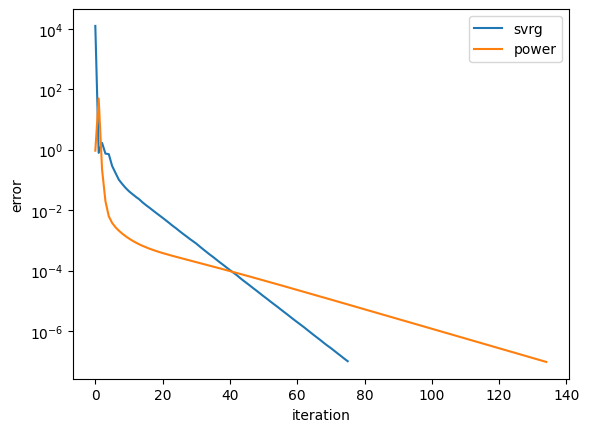

In [101]:

plt.plot(info['errors'],label='svrg')
plt.plot(info2['errors'],label='power')
plt.xlabel('iteration')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
